In [31]:


#data handling and trasformation
import pandas as pd
import numpy as np

# data visualisation 
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve


# machine learning metrics and scoring
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# machine learning models 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')



### Put presets in place

#### Colorblind-friendly palette

In [3]:
# Create an array with the colors you want to use
colors = ["#FF0B04", "#4374B3","#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# Set a custom color palette for colour blind readers

# Assign a name to the palette
colorblind1 = sns.set_palette(sns.color_palette(colors)) 


### Import Data

During the EDA phase, we cleaned the data and separated the dataset into two separate dataframes:

X = the independent variables

y = the target variable


In [4]:
X = pd.read_csv(r'./../data/X.csv') # import the csv file using a relative path to the 'data' folder

#X= X.drop(columns=['Unnamed: 0']) # drop index column

X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [37]:
y = pd.read_csv(r'./../data/y.csv') # import the csv file using a relative path to the 'data' folder
#y= y.drop(columns=['Unnamed: 0']) # drop index column

y.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No


In [7]:
y_cats = y.copy() # make a separate df to preserve the categorical variables
y_cats.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No


### Examine the class label imbalance

In [9]:
## Count instances of the target variable 
#count frequencies
counts = y['offer_accepted'].value_counts()
##count and compute as percentage of total 
pct = y['offer_accepted'].value_counts(normalize=True)

#concatenate results into one DataFrame
pd.concat([counts,pct], axis=1, keys=['n', '%'])

,n,%
No,16955,0.943202
Yes,1021,0.056798


Convert the 'Yes' and 'no' values to '1' and '0'

In [38]:
y['offer_accepted'] = y['offer_accepted'].replace({'No': 0, 'Yes': 1})

In [11]:
neg, pos = np.bincount(y['offer_accepted'])
total = neg + pos

print('Examples:\n    Total: {}\n    Customers who accepted credit card offer: {} ({:.2f}% of total customer base)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 17976
    Customers who accepted credit card offer: 1021 (5.68% of total customer base)



Before applying our machine learning model to improve the balance between 'Yes' and 'No', we need to scale the numerical variables. 

We'll be using standard scaler to remove the mean and unit variance.

In [12]:
independents = X.copy() # make a separate df to preserve the column headers

transformer = StandardScaler().fit(independents)
standard_x = transformer.transform(independents)
X = pd.DataFrame(standard_x)
X.columns = independents.columns # put the column headers back
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,-0.541352,0.121161,-0.476212,0.449452,0.628724,1.223349,-0.267589,0.095704,0.343147,1.410295,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
1,-0.541352,0.121161,1.863330,1.346760,-2.264609,-1.405430,-1.953241,-1.741902,-0.794628,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147
2,1.575537,0.121161,-0.476212,-1.345162,-1.895627,-0.876449,-1.415407,-1.620841,-1.016458,1.410295,-0.007894,1.404533,-0.707372,-0.70198,-0.983886,0.983886,0.418213,-0.418213,-0.738147,0.738147
3,1.575537,-1.133443,-0.476212,0.449452,0.795015,1.076589,1.662932,0.139070,-0.699813,-0.005039,1.215460,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,1.354744,-1.354744
4,-0.541352,0.121161,-0.476212,2.244067,0.772177,1.982953,0.781845,-0.108474,-0.796417,-0.005039,-0.007894,1.404533,-0.707372,-0.70198,1.016378,-1.016378,0.418213,-0.418213,-0.738147,0.738147


#### Optional:

We can plot the data before and after to see if there are any differences.

In [ ]:
sns.pairplot(independents)

In [ ]:
sns.pairplot(X)

In [ ]:
colorblind1 = sns.set_palette(sns.color_palette(colors))

#Create a matrix of panels sharing the same y axis (total claim amount)

fig, axs = plt.subplots(10, 2, figsize=(30, 50)) # width and height 
axs = axs.flatten()
fig.subplots_adjust(hspace=.2, wspace=.2) # ensure that the plots do not overlap


for i, column in enumerate(X.columns):
    sns.histplot(data=X, x=column, palette=sns.color_palette("colorblind"), bins=25, element='step', stat='density', alpha=0.7, ax=axs[i]) # use element='step' to create a histogram-like plot, and stat='density' to normalize the y-axis
    axs[i].set_title(column)

plt.show()


In the countplot below, we see that the majority class, 'No' is much larger than the minority class 'Yes'. 

A possible consequence of this imbalance is that if we attempt to predict acceptance of an offer of a credit card (i.e., a 'yes' or 'no' answer), then our machine learning models risk being biased towards the majority class. They will tend to less accurate when predicting 'Yes'. 

<AxesSubplot: xlabel='offer_accepted', ylabel='count'>

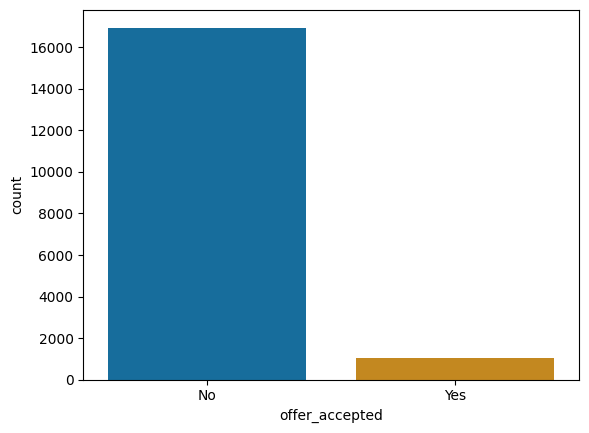

In [58]:
sns.countplot(x=y_cats["offer_accepted"], palette=sns.color_palette("colorblind"))


## Training the data

**test_size** =  proportion of the data that should be used for testing. In this case, 30% of the data will be used for testing, while the remaining 70% will be used for training.

**random_state** = is a parameter that sets the random seed, which ensures that the same random split is generated each time the code is run. This is useful for reproducibility.

The function returns four objects:

#### Indepedent variables

*X_train* is a subset of the input dataset containing the independent variables for the training set.


*X_test* is a subset of the input dataset containing the independent variables for the testing set.

#### Dependent variables

*y_train* is a subset of the target variable corresponding to the observations in X_train.

*y_test* is a subset of the target variable corresponding to the observations in X_test.

By splitting the dataset into training and testing sets, we can train a machine learning model on the training set and evaluate its performance on the testing set. This helps to assess the generalization ability of the model, i.e. how well it can predict on new, unseen data.

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# describes info about train and test set

print("Number CC acceptance X_train dataset: ", X_train.shape)
print("Number CC acceptance y_train dataset: ", y_train.shape)
print("Number CC acceptance X_test dataset: ", X_test.shape)
print("Number CC acceptance y_test dataset: ", y_test.shape)

Number CC acceptance X_train dataset:  (14380, 20)
Number CC acceptance y_train dataset:  (14380, 1)
Number CC acceptance X_test dataset:  (3596, 20)
Number CC acceptance y_test dataset:  (3596, 1)


Then we train a logistic regression classification model on the training data and then use the model to make predictions on new test data.

The predicted labels can then be compared to the true labels (y_test) to evaluate the performance of the model.

In [14]:
from sklearn.linear_model import LogisticRegression

classing = LogisticRegression(random_state=0, multi_class = 'ovr').fit(X_train, y_train)
predictions = classing.predict(X_test)

In [15]:
confusion_matrix(y_test,predictions)

array([[3405,    0],
       [ 191,    0]])

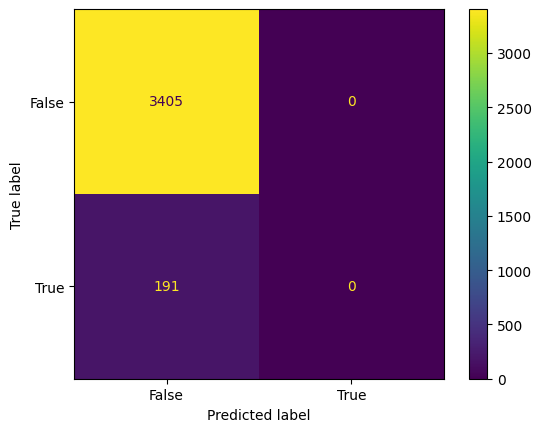

In [16]:

confusion_matrix = metrics.confusion_matrix(y_test, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

<blockquote style="background-color: #F1F8E9; color: #37474F; border-color: #558B2F; padding: 10px; border-radius: 5px;">
            
**Interpreting the confusion matrix:**
    
_____________

From the above confusion matrix, we can see that we were able to predict:

- **3405 True Negatives (Top-Left Quadrant)**
- O False Positives (Top-Right Quadrant)
- 191 False Negatives (Bottom-Left Quadrant)
- O True Positives (Bottom-Right Quadrant)

This suggests that our model is heavily biased towards true negatives or the 'No', i.e, rejecting the credit card.
_____________
</blockquote>

When we run our classing score function, we see that the R2 is very high:

0.95

<blockquote style="background-color: #E3F2FD; color: #37474F; border-color: #1565C0; padding: 10px; border-radius: 5px;">
            
##  📊 Evaluating our data : 📊
    
_____________

**Classification score:** This is a general term that refers to any metric that measures the performance of a classification model. It can refer to any of the other metrics listed below, such as accuracy, precision, recall, or F1-score.

**Accuracy:** This is the most common metric for evaluating the performance of a classification model. It measures the proportion of correctly classified instances (both true positives and true negatives) out of all instances in the dataset.

**Precision:** Precision measures the proportion of correctly predicted positive instances (true positives) out of all instances predicted as positive (both true positives and false positives). It is a measure of the model's ability to correctly identify positive instances.

**Recall:** Recall (also known as sensitivity) measures the proportion of correctly predicted positive instances (true positives) out of all actual positive instances (both true positives and false negatives). It is a measure of the model's ability to identify all positive instances.

**F1-score:** F1-score is a harmonic mean of precision and recall, and provides a balanced measure between the two. It ranges between 0 and 1, with higher values indicating better performance. It is calculated as 2 * (precision * recall) / (precision + recall).

**AUC-ROC:** AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a metric that measures the ability of a binary classification model to distinguish between positive and negative instances. It is calculated by plotting the true positive rate (recall) against the false positive rate (1 - specificity) at different classification thresholds, and calculating the area under the resulting curve. The AUC-ROC ranges from 0 to 1, with higher values indicating better performance.

In [17]:
classing.score(X_test,y_test)

0.9468854282536151

And the accuracy score is identical:

0.95

In [18]:
Accuracy = metrics.accuracy_score(y_test, predictions) # same as the classing score 
Accuracy

0.9468854282536151

In [19]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3405
           1       0.00      0.00      0.00       191

    accuracy                           0.95      3596
   macro avg       0.47      0.50      0.49      3596
weighted avg       0.90      0.95      0.92      3596



If we run an f-1 score we can see that accuracy is identical (.95)

| precision | recall | f1-score | support |
| --------- | ------ | -------- | ------- |
| 0.95      | 1      | 0.97     | 3405    |
| 0         | 0      | 0        | 191     |
| accuracy  |        | 0.95     | 3596    |

## Resampling the data 

To balance the data, we'll try oversampling using the Synthetic Minority Over-sampling Technique (SMOTE). This will balance the class distribution of the target variable 'offer_accepted'.

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = independents[['bank_accounts_open',
 'credit_cards_held',
 'homes_owned',
 'household_size',
 'average_balance',
 'q1_balance',
 'q2_balance',
 'q3_balance',
 'q4_balance',
 'income_level',
 'credit_rating',
 'reward_Air Miles',
 'reward_Cash Back',
 'reward_Points',
 'mailer_type_Letter',
 'mailer_type_Postcard',
 'overdraft_protection_No',
 'overdraft_protection_Yes',
 'own_your_home_No',
 'own_your_home_Yes']]
transformer = StandardScaler().fit(X)
X = transformer.transform(X)
y = y_cats['offer_accepted']
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     16955
Yes    16955
Name: offer_accepted, dtype: int64

The classes have been balanced using SMOTE, so you can see that the number of samples with label Yes is equal to the number of samples with label No. This means that the class distribution is now even, with both classes having the same number of samples (in this case, 16955).

Now our model has a lower classification score:

From 0.95 to 0.70

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)
classification = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)
predictions = classification.predict(X_test)
classification_score = classification.score(X_test, y_test)




In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=100)

# Train a logistic regression model
model = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the performance using various metrics
classification_score = classification.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') #  give more importance to the performance on the positive class
recall = recall_score(y_test, y_pred, average='weighted') # give more importance to the performance on the positive class
f1 = f1_score(y_test, y_pred, average='weighted') # give more importance to the performance on the positive class
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the results
print("Classification score:", classification_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)


Classification score: 0.7029391526589993
Accuracy: 0.7029391526589993
Precision: 0.7046232643185588
Recall: 0.7029391526589993
F1-score: 0.7025669376784855
AUC-ROC: 0.7731895673832054


In [ ]:
# Plot the logistic regression curve
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], y_test, color='black', label='data')
plt.plot(X_test[:, 0], model.predict(X_test), color='blue', linewidth=3, label='Logistic regression')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Logistic Regression Curve')
plt.legend()
plt.show()

# Plot the ROC-AUC curve
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

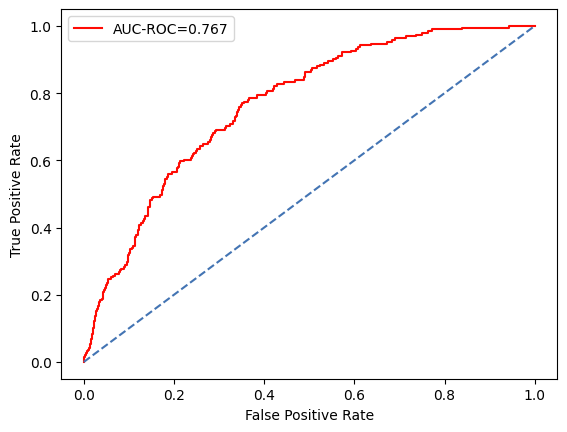

In [46]:

from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# predict probabilities of positive class
y_probs = model.predict_proba(X_test)[:, 1]

# calculate AUC-ROC score
auc_score = roc_auc_score(y_test, y_probs)

# calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# plot ROC curve
plt.plot(fpr, tpr, label=f'AUC-ROC={auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### UnderSampling using TomekLinks 

In [48]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(X, y_cats)
y_tl.value_counts(normalize=True)

offer_accepted
No                0.941674
Yes               0.058326
dtype: float64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.3, random_state=100)
classification = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)

# Make predictions on the testing set
y_pred = classification.predict(X_test)

# Evaluate the performance using various metrics
classification.score(X_test, y_test)

auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Evaluate the performance using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') #  give more importance to the performance on the positive class
recall = recall_score(y_test, y_pred, average='weighted') # give more importance to the performance on the positive class
f1 = f1_score(y_test, y_pred, average='weighted') # give more importance to the performance on the positive class
auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# Print the results
print("Classification score:", classification_score)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)



Classification score: 0.9364051789794364
Accuracy: 0.9364051789794364
Precision: 0.8768546592195103
Recall: 0.9364051789794364
F1-score: 0.9056520492076438
AUC-ROC: 0.7441952207825099


The AUC-ROC score may be lower than the other metrics if the model is making many false positive predictions, which would be penalized more heavily when the decision threshold is set higher.

However, we've seen that our model makes more false-negative predictions. 

<blockquote style="background-color: #F1F8E9; color: #37474F; border-color: #558B2F; padding: 10px; border-radius: 5px;">
        
_____________

## 🚧 analysis & next steps 🚧 

learning towards towards the SMOTE for now
- the AUC-ROC in tomek links is lower than smote
- the accuracy, recall, f1 are all in the 90s that suggests that the majority class (i.e., No) is still over represented 



To do:

- Choose which features have the bigget effect on imbalance 
- yes and not is affected by these features

- run a model with the greatest predictive value 
- rule out variables that are less important
- which scaler performed the best and why
cf. 
sklearn feature importance  logitic regression 



_____________
</blockquote>



# temporary commands & to do


In [ ]:

y.head()